# Accessing release 2.1 of the Chandra Source Catalog with PyVO and CIAO tools, with basic science applications using astropy and scikit-learn 
### Original notebook by Doug Burke, expanded by Rafael Martinez-Galarza

Version 2.1 of the Chandra Source Catalog, currenty in production, significantly expands version 2.0 by adding approximately 100,000 individual in the sky to the previously published 317,000 sources. CSC 2.1 sources that have completed processing are now available to the users in the Current Database View of the catalog. See the [CSS 2.1 documentation pages](https://cxc.cfa.harvard.edu/csc/about2.1.html) for all the details. 

In this notebook we show how you can use [PyVo](https://pyvo.readthedocs.io/) to query [releases 2.0 and 2.1 of the Chandra Source Catalog](https://cxc.cfa.harvard.edu/csc2/) using the [VO interfaces](https://cxc.harvard.edu/csc/download.html#vo) for tabulated properties, and [CIAO](https://cxc.cfa.harvard.edu/ciao/) tools to retrieve catalog data products. We also show how to use [astropy](https://www.astropy.org/) to perform cross-matches with other catalogs, and some basic applications in machine learning with [scikit-learn](https://scikit-learn.org/stable/).

This notebook assumes you have installed CIAO 4.15 using conda, but you should also be able to do this with a CIAO installed using the `ciao-install` script, or any other Python environment as we are just going to use [Astropy](https://www.astropy.org/) along with `pyvo`. The `pyyaml` poackage is needed to support writing out the file (it avoids a warning message you would get). For CIAO 4.15 installation instructions, check the [CIAO pages](https://cxc.cfa.harvard.edu/ciao/threads/ciao_install_conda/).

Packages to install:

 - `pip install astropy pyvo pyyaml matplotlib`
 - `pip install pyvo`
 - `pip install -U scikit-learn`
 - `pip install bxa`

In [1]:
# Basic numeric and plotting imports

import numpy as np
import scipy

from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors

# Astropy/Astroquery imports

import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astroquery.vizier import Vizier
import astroquery
from astroquery.gaia import Gaia

# PyVO import

import pyvo as vo

# CIAO/Sherpa imports

from ciao_contrib.runtool import search_csc
from sherpa.astro import ui

# BXA import (Bayesian fitting)

import bxa.sherpa as bxa

# Scikit-learn import (for ML)

from sklearn.cluster import KMeans

# Other imports

import warnings
warnings.filterwarnings('ignore')

# Set a variable for the path of the directory where you want to save your results

PATH = "/Users/juan/L3/tutorial/"


%matplotlib inline

Let's just check the versions (it is expected that the results should not depend on these versions):

In [2]:
print("Versions:")
print(f"  NumPy       - {np.__version__}")
print(f"  Matplotlib  - {matplotlib.__version__}")
print(f"  AstroPy     - {astropy.__version__}")
print(f"  PyVO        - {vo.__version__}")

Versions:
  NumPy       - 1.23.5
  Matplotlib  - 3.6.2
  AstroPy     - 5.2
  PyVO        - 1.4


## Aim

This document will show you how to:

* Use a cone search - that is, find results around a given location - and then run a general "database query", which can be done over the whole sky. The Virtual Observatory cone-search interface is "simple", in that you give it a location, radius, and an optional "verbosity" parameter between 1 and 3, inclusive, that controls the number of columns that gets returned. The details can be found at the [CSC 2.0 cone search](http://cda.cfa.harvard.edu/cscvo/) page.

* Use the Table Access Protocol (TAP) service, for performing specific queries of CSC2 tables, allowing much-more general queries. It is suggested that you use [CSCView](http://cda.harvard.edu/cscview/) to create a query, and then view the query - using the `View/Query/Show Language` menu item - to see what query it has created: this is important for complex queries where you are trying to access data from multiple tables (e.g. observation-level fluxes mapped to a given master source), since there are many "hidden" traps in these queries which CSCView knows about.

* Cross-match the CSC 2.1 catalog with other catalogs, and visualize the results.

* Download data products from the CSC 2.1, such as light curves and spectra, and visualize them for science applications.

* Fitting X-ray spectra with Sherpa and BXA (Bayesian nested sampling).

* Input CSC 2.1 data to a machine learning algorithm.

## Cone Search

Let's start with using cone search in order to find CSC 2.1 sources near the M51 galaxy. Cone search will only query the maste level tables (you need to use TAP interfaces, see below, to query per-obsid properties). We will use a search radius of 40 arcminutes. We will use the name resolver from Astropy. Here is a visualization of the CSC 2.1 sources in this area, from [our World Wide Telescope interface](https://cxc.cfa.harvard.edu/csc/wwt21.html#):

![M51](m51.png)


In [3]:
m51 = SkyCoord.from_name('M51')
maxrad = 40.0 * u.arcmin

In [4]:
m51

<SkyCoord (ICRS): (ra, dec) in deg
    (202.469575, 47.1952583)>

We now need a Python object representing the 
[CSC 2.0 and CSC 2.1 Virtual Observatory Cone Search Services](http://cda.cfa.harvard.edu/cscvo/). For CSC 2.1, for example, the base URL is `https://cda.cfa.harvard.edu/csc21_snapshot_scs/coneSearch`:

In [5]:
cone_20 = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch') # For CSC 2.0
cone_21 = vo.dal.SCSService('https://cda.cfa.harvard.edu/csc21_snapshot_scs/coneSearch') # For CSC 2.1

To run the search we are going to use the `search` method, which (fortunately for this notebook) has a short help page so I can include it:

In [6]:
help(cone_21.search)

Help on method search in module pyvo.dal.scs:

search(pos, radius=1.0, verbosity=2, **keywords) method of pyvo.dal.scs.SCSService instance
    submit a simple Cone Search query that requests objects or observations
    whose positions fall within some distance from a search position.
    
    Parameters
    ----------
    pos : astropy.coordinates.SkyCoord
        a SkyCoord instance defining the position of the center of the
        circular search region.
        converted if it's a iterable containing scalars,
        assuming icrs degrees.
    radius : `~astropy.units.Quantity` or float
        a Quantity instance defining the radius of the circular search
        region, in degrees.
        converted if it is another unit.
    verbosity : int
       an integer value that indicates the volume of columns
       to return in the result table.  0 means the minimum
       set of columns, 3 means as many columns as are available.
    **keywords :
       additional case insensitive param

We can then run the two queries with the following (the arguments don't need to be named but it makes things a bit clearer to be explicit):

In [7]:
result_20 = cone_20.search(pos=m51, radius=maxrad, verbosity=3)
result_21 = cone_21.search(pos=m51, radius=maxrad, verbosity=3)

We can now see how many sources each query returns. CSC 2.1 includes newer observations in addition to those from which CSC 2.0 was produced, including new observations that overlap the region of M51. This results in better overall source detectability, and an increased number of sources. 

In [8]:
print('Number of M51 sources in CSC 2.0: ',len(result_20))
print('Number of M51 sources in CSC 2.1: ',len(result_21))

Number of M51 sources in CSC 2.0:  505
Number of M51 sources in CSC 2.1:  520


Let's print the table with the results of the query.

In [9]:
result_21

<Table length=520>
         name                 ra         ... hrc_hetg_time hrc_letg_time
                             deg         ...       s             s      
        object             float64       ...    float64       float64   
--------------------- ------------------ ... ------------- -------------
2CXO J132833.9+471646 202.14128895058525 ...            --            --
2CXO J132836.5+471602 202.15237275644722 ...            --            --
2CXO J132836.6+471229 202.15266398562972 ...            --            --
2CXO J132836.7+471043  202.1530198996461 ...            --            --
2CXO J132838.3+471120 202.15981819552053 ...            --            --
2CXO J132841.6+471416 202.17335871218359 ...            --            --
                  ...                ... ...           ...           ...
2CXO J133100.2+470836 202.75085816059652 ...            --            --
2CXO J133105.7+470617 202.77413798830275 ...            --            --
2CXO J133109.6+471015 202.790534

The fact that the source names begin with '2CXO' means that we are indeed searching release 2.X, as opposed to the 1.X series. Let's see what the default columns are (note that this search was run with the cone-search `verbosity` parameter set to 3, which http://cda.cfa.harvard.edu/cscvo/ tells us returns all CSC columns at the master level.

The results can be converted to an AstroPy table - using `results.to_table()`, which we use below - but they can also be used directly:

In [10]:
# Let's print the first 50 fields
result_21.fieldnames[0:50]

('name',
 'ra',
 'dec',
 'err_ellipse_r0',
 'err_ellipse_r1',
 'err_ellipse_ang',
 'gal_b',
 'gal_l',
 'extent_flag',
 'conf_flag',
 'pileup_flag',
 'var_flag',
 'streak_src_flag',
 'sat_src_flag',
 'man_add_flag',
 'man_inc_flag',
 'man_reg_flag',
 'man_match_flag',
 'man_pos_flag',
 'var_inter_hard_flag',
 'major_axis_b',
 'major_axis_h',
 'major_axis_m',
 'major_axis_s',
 'major_axis_u',
 'major_axis_w',
 'major_axis_lolim_b',
 'major_axis_lolim_h',
 'major_axis_lolim_m',
 'major_axis_lolim_s',
 'major_axis_lolim_u',
 'major_axis_lolim_w',
 'major_axis_hilim_b',
 'major_axis_hilim_h',
 'major_axis_hilim_m',
 'major_axis_hilim_s',
 'major_axis_hilim_u',
 'major_axis_hilim_w',
 'minor_axis_b',
 'minor_axis_h',
 'minor_axis_m',
 'minor_axis_s',
 'minor_axis_u',
 'minor_axis_w',
 'minor_axis_lolim_b',
 'minor_axis_lolim_h',
 'minor_axis_lolim_m',
 'minor_axis_lolim_s',
 'minor_axis_lolim_u',
 'minor_axis_lolim_w')

In [11]:
# Print the first 50 entries
result_21['name'][0:50]

masked_array(data=['2CXO J132833.9+471646', '2CXO J132836.5+471602',
                   '2CXO J132836.6+471229', '2CXO J132836.7+471043',
                   '2CXO J132838.3+471120', '2CXO J132841.6+471416',
                   '2CXO J132841.9+471229', '2CXO J132843.2+471624',
                   '2CXO J132844.5+470750', '2CXO J132845.0+471107',
                   '2CXO J132847.1+470818', '2CXO J132848.3+471208',
                   '2CXO J132848.5+470624', '2CXO J132849.2+471747',
                   '2CXO J132850.0+470038', '2CXO J132850.9+471902',
                   '2CXO J132854.6+470810', '2CXO J132857.7+472035',
                   '2CXO J132858.3+471153', '2CXO J132858.9+471803',
                   '2CXO J132900.3+471945', '2CXO J132900.5+471140',
                   '2CXO J132900.8+471354', '2CXO J132901.4+470329',
                   '2CXO J132903.4+470231', '2CXO J132906.6+470912',
                   '2CXO J132907.0+471124', '2CXO J132907.6+472138',
                   '2CXO J132908.0

We can iterate through the sources, and print, for example, their aperture photometry fluxes in the b band, and their limits, only for sources that have a significance (or signal to noise ratio) larger than 50:

In [12]:
for r in result_21:
    if (r['significance']>50.0):
        out = f"{r['name']} flux={r['flux_aper_b']:.3e}  "
        out += f"{r['flux_aper_lolim_b']:.3e} - {r['flux_aper_hilim_b']:.3e}"
        print(out)

2CXO J132939.4+471243 flux=8.769e-14  8.603e-14 - 8.925e-14
2CXO J132939.9+471236 flux=6.795e-14  6.682e-14 - 6.908e-14
2CXO J132943.3+471134 flux=4.036e-14  3.898e-14 - 4.166e-14
2CXO J132946.1+471042 flux=6.517e-14  6.327e-14 - 6.706e-14
2CXO J132950.6+471155 flux=6.533e-14  6.333e-14 - 6.732e-14
2CXO J132952.7+471142 flux=9.086e-14  8.906e-14 - 9.254e-14
2CXO J132952.7+471139 flux=7.372e-14  7.272e-14 - 7.467e-14
2CXO J132953.7+471435 flux=1.228e-13  1.208e-13 - 1.249e-13
2CXO J132954.0+471150X flux=nan  nan - nan
2CXO J132957.5+471048 flux=4.601e-14  4.493e-14 - 4.709e-14
2CXO J132957.6+471206 flux=3.856e-14  3.788e-14 - 3.920e-14
2CXO J132959.0+471318 flux=2.192e-13  2.173e-13 - 2.211e-13
2CXO J133001.0+471343 flux=3.676e-13  3.627e-13 - 3.726e-13
2CXO J133004.3+471320 flux=7.670e-14  7.464e-14 - 7.864e-14
2CXO J133007.5+471106 flux=2.232e-13  2.201e-13 - 2.263e-13


Let's display the location on the sky of these sources, and color code by significance:

Text(0, 0.5, 'log(significance)')

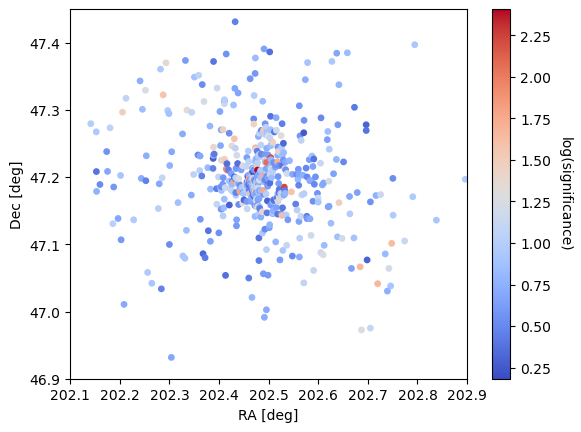

In [13]:
cmap = cm.coolwarm
normalize = matplotlib.colors.Normalize(vmin=np.min(np.log10(result_21['significance'].data)), 
                                        vmax=np.max(np.log10(result_21['significance'].data)))
plt.scatter(result_21['ra'],result_21['dec'],cmap=cmap,norm=normalize,c=np.log10(result_21['significance'].data),s=15)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.xlim(202.1,202.9)
plt.ylim(46.9,47.45)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(significance)', rotation=270)

Now let's simultaneously visualize the spectral and variability probabilities of these sources by plotting the hardness ratios, and color coding them by variability probability, both at short timescales (intra-observation variability), and long timescales (inter-observation variability):

Text(0.5, 1.0, 'Long term variability')

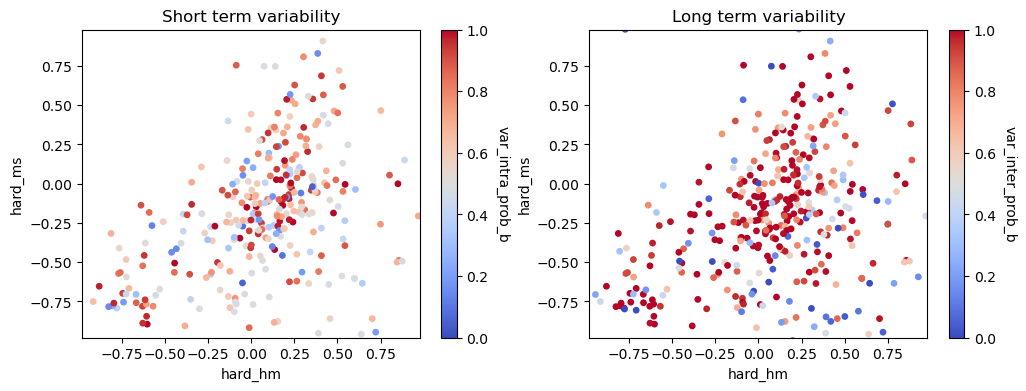

In [14]:
plt.subplots(figsize=(12, 4))
cmap = cm.coolwarm
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
plt.subplot(1,2,1)
plt.scatter(result_21['hard_hm'],result_21['hard_ms'],cmap=cmap,norm=normalize,c=result_21['var_intra_prob_b'].data,s=15)
plt.xlim(-0.98,0.98)
plt.ylim(-0.98,0.98)
cbar = plt.colorbar()
plt.xlabel('hard_hm')
plt.ylabel('hard_ms')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('var_intra_prob_b', rotation=270)
plt.title('Short term variability')
plt.subplot(1,2,2)
plt.scatter(result_21['hard_hm'],result_21['hard_ms'],cmap=cmap,norm=normalize,c=result_21['var_inter_prob_b'].data,s=15)
plt.xlim(-0.98,0.98)
plt.ylim(-0.98,0.98)
cbar = plt.colorbar()
plt.xlabel('hard_hm')
plt.ylabel('hard_ms')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('var_inter_prob_b', rotation=270)
plt.title('Long term variability')

### Improved detectability in CSC 2.1

With the addition of new observations in CSC 2.1, the effect on detectability can be quite impressive in some cases. Let's take, for example, a field corresponding to the cluster of galaxies ACO 1914. In this region, a stack containing 5 observations has been added as apart of CSC 2.1. Let's see what the effect of this additional observations is in the number of sources in the field, and the significance of those detections. Let's star by doing a cone search around the cluster, with a 1 degree search radius, and print the total number of sources in CSC 2.0 vs CSC 2.1.

In [15]:
aco = SkyCoord.from_name('ACO 1914')
maxrad = 1.0 * u.deg

result_20 = cone_20.search(pos=aco, radius=maxrad, verbosity=3)
result_21 = cone_21.search(pos=aco, radius=maxrad, verbosity=3)

print('Number of M51 sources in CSC 2.0: ',len(result_20))
print('Number of M51 sources in CSC 2.1: ',len(result_21))

Number of M51 sources in CSC 2.0:  137
Number of M51 sources in CSC 2.1:  222


It looks like we have gained over 80 new sources in this field. Let's plot the sources and their significance. You will notice that apart from there being new sources the overall significance of the detections has increased for sources that were already in CSC 2.0.

Text(0.5, 1.0, 'CSC 2.1')

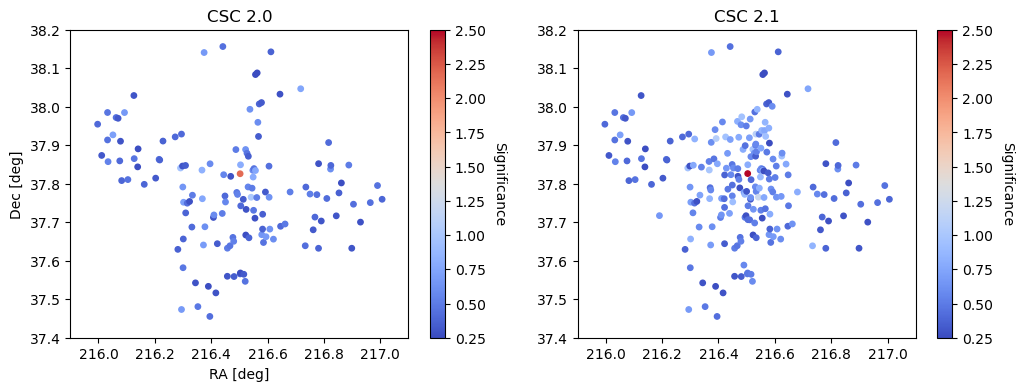

In [16]:
plt.subplots(figsize=(12, 4))
cmap = cm.coolwarm
plt.subplot(1,2,1)
normalize = matplotlib.colors.Normalize(vmin=0.25, 
                                        vmax=2.5)
plt.scatter(result_20['ra'],result_20['dec'],cmap=cmap,norm=normalize,c=np.log10(result_20['significance'].data),s=15)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.xlim(215.9,217.1)
plt.ylim(37.4,38.2)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Significance', rotation=270)
plt.title('CSC 2.0')
plt.subplot(1,2,2)
normalize = matplotlib.colors.Normalize(vmin=0.25, 
                                        vmax=2.5)
plt.scatter(result_21['ra'],result_21['dec'],cmap=cmap,norm=normalize,c=np.log10(result_21['significance'].data),s=15)
plt.xlim(215.9,217.1)
plt.ylim(37.4,38.2)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Significance', rotation=270)
plt.title('CSC 2.1')

### Saving data

Let's try to save the search results as a FITS table. Unfortunately for us the name column
is being turned into a Python object rather than a string, which causes the conversion to FITS to fail. This
appears to be a choice with how AstroPy [handles string columns of unrestricted length](https://docs.astropy.org/en/stable/io/votable/#datatype-mappings), so one solution is to manually convert the name field to string values.

In [17]:
result_21.votable.get_field_by_id_or_name('name')

<FIELD ID="name" arraysize="*" datatype="char" name="name"/>

In [18]:
tbl = result_21.to_table()

The `name` column starts out as having a data type of `object` (as the string names are normally 21 characters long but can be 22).

A quick conversion is to just use `str`:

In [19]:
for key in tbl.keys():
    if tbl[key].dtype == 'O':
        tbl[key] = [str(n) for n in tbl[key]]

The output for a AstroPy Table is slightly different:

In [20]:
tbl

name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,gal_b,gal_l,extent_flag,conf_flag,pileup_flag,var_flag,streak_src_flag,sat_src_flag,man_add_flag,man_inc_flag,man_reg_flag,man_match_flag,man_pos_flag,var_inter_hard_flag,major_axis_b,major_axis_h,major_axis_m,major_axis_s,major_axis_u,major_axis_w,major_axis_lolim_b,major_axis_lolim_h,major_axis_lolim_m,major_axis_lolim_s,major_axis_lolim_u,major_axis_lolim_w,major_axis_hilim_b,major_axis_hilim_h,major_axis_hilim_m,major_axis_hilim_s,major_axis_hilim_u,major_axis_hilim_w,minor_axis_b,minor_axis_h,minor_axis_m,minor_axis_s,minor_axis_u,minor_axis_w,minor_axis_lolim_b,minor_axis_lolim_h,minor_axis_lolim_m,minor_axis_lolim_s,minor_axis_lolim_u,minor_axis_lolim_w,minor_axis_hilim_b,minor_axis_hilim_h,minor_axis_hilim_m,minor_axis_hilim_s,minor_axis_hilim_u,minor_axis_hilim_w,pos_angle_b,pos_angle_h,pos_angle_m,pos_angle_s,pos_angle_u,pos_angle_w,pos_angle_lolim_b,pos_angle_lolim_h,pos_angle_lolim_m,pos_angle_lolim_s,pos_angle_lolim_u,pos_angle_lolim_w,pos_angle_hilim_b,pos_angle_hilim_h,pos_angle_hilim_m,pos_angle_hilim_s,pos_angle_hilim_u,pos_angle_hilim_w,src_area_b,src_area_h,src_area_m,src_area_s,src_area_u,src_area_w,phot_nsrcs,photflux_aper_b,photflux_aper_h,photflux_aper_m,photflux_aper_s,photflux_aper_u,photflux_aper_w,photflux_aper_lolim_b,photflux_aper_lolim_h,photflux_aper_lolim_m,photflux_aper_lolim_s,photflux_aper_lolim_u,photflux_aper_lolim_w,photflux_aper_hilim_b,photflux_aper_hilim_h,photflux_aper_hilim_m,photflux_aper_hilim_s,photflux_aper_hilim_u,photflux_aper_hilim_w,photflux_aper90_b,photflux_aper90_h,photflux_aper90_m,photflux_aper90_s,photflux_aper90_u,photflux_aper90_w,photflux_aper90_lolim_b,photflux_aper90_lolim_h,photflux_aper90_lolim_m,photflux_aper90_lolim_s,photflux_aper90_lolim_u,photflux_aper90_lolim_w,photflux_aper90_hilim_b,photflux_aper90_hilim_h,photflux_aper90_hilim_m,photflux_aper90_hilim_s,photflux_aper90_hilim_u,photflux_aper90_hilim_w,flux_aper_b,flux_aper_h,flux_aper_m,flux_aper_s,flux_aper_u,flux_aper_w,flux_aper_lolim_b,flux_aper_lolim_h,flux_aper_lolim_m,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_w,flux_aper_hilim_b,flux_aper_hilim_h,flux_aper_hilim_m,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_w,flux_aper90_b,flux_aper90_h,flux_aper90_m,flux_aper90_s,flux_aper90_u,flux_aper90_w,flux_aper90_lolim_b,flux_aper90_lolim_h,flux_aper90_lolim_m,flux_aper90_lolim_s,flux_aper90_lolim_u,flux_aper90_lolim_w,flux_aper90_hilim_b,flux_aper90_hilim_h,flux_aper90_hilim_m,flux_aper90_hilim_s,flux_aper90_hilim_u,flux_aper90_hilim_w,photflux_aper_avg_b,photflux_aper_avg_h,photflux_aper_avg_m,photflux_aper_avg_s,photflux_aper_avg_u,photflux_aper_avg_w,photflux_aper_avg_lolim_b,photflux_aper_avg_lolim_h,photflux_aper_avg_lolim_m,photflux_aper_avg_lolim_s,photflux_aper_avg_lolim_u,photflux_aper_avg_lolim_w,photflux_aper_avg_hilim_b,photflux_aper_avg_hilim_h,photflux_aper_avg_hilim_m,photflux_aper_avg_hilim_s,photflux_aper_avg_hilim_u,photflux_aper_avg_hilim_w,photflux_aper90_avg_b,photflux_aper90_avg_h,photflux_aper90_avg_m,photflux_aper90_avg_s,photflux_aper90_avg_u,photflux_aper90_avg_w,photflux_aper90_avg_lolim_b,photflux_aper90_avg_lolim_h,photflux_aper90_avg_lolim_m,photflux_aper90_avg_lolim_s,photflux_aper90_avg_lolim_u,photflux_aper90_avg_lolim_w,photflux_aper90_avg_hilim_b,photflux_aper90_avg_hilim_h,photflux_aper90_avg_hilim_m,photflux_aper90_avg_hilim_s,photflux_aper90_avg_hilim_u,photflux_aper90_avg_hilim_w,flux_aper_avg_b,flux_aper_avg_h,flux_aper_avg_m,flux_aper_avg_s,flux_aper_avg_u,flux_aper_avg_w,flux_aper_avg_lolim_b,flux_aper_avg_lolim_h,flux_aper_avg_lolim_m,flux_aper_avg_lolim_s,flux_aper_avg_lolim_u,flux_aper_avg_lolim_w,flux_aper_avg_hilim_b,flux_aper_avg_hilim_h,flux_aper_avg_hilim_m,flux_aper_avg_hilim_s,flux_aper_avg_hilim_u,flux_aper_avg_hilim_w,flux_aper90_avg_b,flux_aper90_avg_h,flux_aper90_avg_m,flux_aper90_avg_s,flux_aper90_avg_u,flux_aper90_avg_w,flux_aper90_avg_lolim_b,flux_aper90_avg_lolim_h,flux_aper9

Finally the file can be written out as a FITS table:

In [21]:
tbl.meta['description'] = u'Sources in ACO 1914'
tbl.write(PATH+'aco_v3.fits', format='fits', overwrite=True)

## Moving to TAP queries (general queries)

For an all-sky search we are going to switch to the [Table Access Protocol](http://cda.cfa.harvard.edu/csctap/) search. This has a base URL of `http://cda.cfa.harvard.edu/csc2tap` and requires us writing a query using the [Astronomical Data Query Language (ADQL)](https://wiki.ivoa.net/twiki/bin/view/IVOA/ADQL). In this particular case, we are going to do a simple search and return a subset of the columns that we got back from the cone search:

```
SELECT m.name, m.ra, m.dec, m.conf_flag, m.significance, m.extent_flag, m.sat_src_flag,
       m.flux_aper_b, m.flux_aper_lolim_b, m.flux_aper_hilim_b
FROM csc21_snapshot.master_source m
WHERE m.name LIKE '%X'
```

In [22]:
tap_20 = vo.dal.TAPService('http://cda.cfa.harvard.edu/csc2tap') # For CSC 2.0
tap_21 = vo.dal.TAPService('https://cda.cfa.harvard.edu/csc21_snapshot_tap') # For CSC 2.1

We can check what tables are available (although we are focussed on the "master source" table, it's useful to know what else is available):

In [23]:
for i, tblname in enumerate(tap_21.tables.keys()):
    print(f"{i + 1:2d} - {tblname}")

 1 - TAP_SCHEMA.schemas
 2 - TAP_SCHEMA.tables
 3 - TAP_SCHEMA.columns
 4 - TAP_SCHEMA.keys
 5 - TAP_SCHEMA.key_columns
 6 - ivoa.ObsCore
 7 - csc21_snapshot.cone
 8 - csc21_snapshot.image
 9 - csc21_snapshot.master_source
10 - csc21_snapshot.stack_source
11 - csc21_snapshot.observation_source
12 - csc21_snapshot.master_stack_assoc
13 - csc21_snapshot.stack_observation_assoc
14 - csc21_snapshot.detect_stack
15 - csc21_snapshot.valid_stack
16 - csc21_snapshot.likely_stack


### Extended sources
Let's try the simple query. This asks for master-source properties on all the "extended" sources in the catalog (where "extended" means large-diffuse emission, and not slightly-larger-than-a-point-source extended):

In [24]:
qry_20 = """
SELECT m.name, m.ra, m.dec, m.conf_flag, m.significance, m.extent_flag, m.sat_src_flag,
       m.flux_aper_avg_b, m.flux_aper_avg_lolim_b, m.flux_aper_avg_hilim_b
FROM csc2.master_source m
WHERE m.name LIKE '%X'
"""



qry_21 = """
SELECT m.name, m.ra, m.dec, m.conf_flag, m.significance, m.extent_flag, m.sat_src_flag,
       m.flux_aper_avg_b, m.flux_aper_avg_lolim_b, m.flux_aper_avg_hilim_b
FROM csc21_snapshot.master_source m
WHERE m.name LIKE '%X'
"""

In [25]:
tresults_20 = tap_20.search(qry_20)
tresults_21 = tap_21.search(qry_21)

Let's see how many extended sources there are in each version of the caalog

In [26]:
print('There are ',len(tresults_20), ' extended sources in CSC 2.0')
print('There are ',len(tresults_21), ' extended sources in CSC 2.1')

There are  1299  extended sources in CSC 2.0
There are  1610  extended sources in CSC 2.1


In [27]:
fluxes_ext = tresults_21['flux_aper_avg_b']
fluxes_ext1 = fluxes_ext[fluxes_ext>0]

Let's check the sky distribution and the fluxes for these extended sources, which should cover most of the sky (excluding poles and a band close to the plane):

-15.214243682432903 -8.721726743932795


Text(0, 0.5, 'log(F$_X$) [erg/s/cm$^2$]')

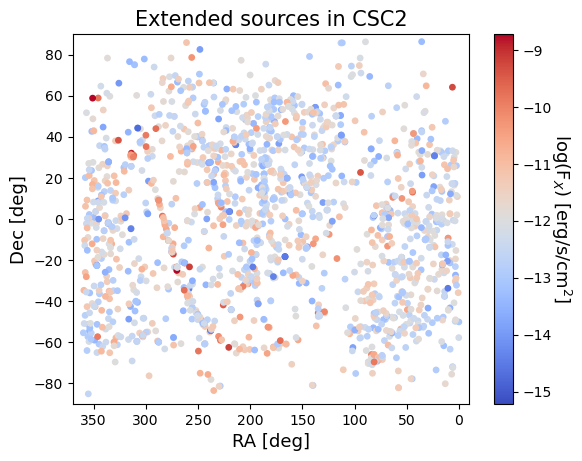

In [28]:
#plt.plot(tresults['ra'], tresults['dec'], 'o')
plt.title('Extended sources in CSC2')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.ylim(-90, 90)
plt.xlim(370, -10);

min_norm = np.min(np.log10(fluxes_ext1))
max_norm = np.max(np.log10(fluxes_ext1))

print(min_norm,max_norm)

normalize = matplotlib.colors.Normalize(vmin=min_norm, 
                                        vmax=max_norm)
plt.scatter(tresults_21['ra'][fluxes_ext>0],tresults_21['dec'][fluxes_ext>0],cmap=cmap,norm=normalize,
            c=np.log10(tresults_21['flux_aper_avg_b'].data[fluxes_ext>0]),s=15)
plt.xlabel('RA [deg]',size=13)
plt.ylabel('Dec [deg]',size=13)
plt.title('Extended sources in CSC2',size=15)
plt.ylim(-90, 90)
plt.xlim(370, -10);
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(F$_X$) [erg/s/cm$^2$]', rotation=270,size=13)

### Per-obsid search
Let's now try a search of the entire catalog for source detections that have significance larger than 10, and that are not flagged for saturation of for streaks. Let's also select detections that are uniquely associated with a master source. We will explore the distributions of the short term variability for these sources

In [29]:
qry = """
SELECT m.name,m.ra,m.dec,m.err_ellipse_r0,m.err_ellipse_r1,m.err_ellipse_ang,
    m.likelihood_class,a.match_type,o.obsid,o.obi,o.region_id,o.theta,o.phi,o.flux_significance_b,
    o.likelihood_b,o.conf_code,o.dither_warning_flag,o.extent_code,o.sat_src_flag,o.streak_src_flag,
    o.var_code,o.flux_aper_b,o.flux_aper_lolim_b,o.flux_aper_hilim_b,o.var_index_b,o.var_index_h,
    o.var_index_m,o.var_index_s,o.var_index_u,o.var_prob_b,o.var_prob_h,o.var_prob_m,o.var_prob_s,
    o.var_prob_u,o.ks_prob_b,o.ks_prob_h,o.ks_prob_m,o.ks_prob_s,o.ks_prob_u,o.var_sigma_b,
    o.var_sigma_h,o.var_sigma_m,o.var_sigma_s,o.var_sigma_u,o.var_mean_b,o.var_mean_h,
    o.var_mean_m,o.var_mean_s,o.var_mean_u,o.var_min_b,o.var_min_h,o.var_min_m,o.var_min_s,
    o.var_min_u,o.var_max_b,o.var_max_h,o.var_max_m,o.var_max_s,o.var_max_u 
FROM csc21_snapshot.master_source m , csc21_snapshot.master_stack_assoc a , csc21_snapshot.observation_source o , 
    csc21_snapshot.stack_observation_assoc b , csc21_snapshot.stack_source s 
WHERE ((a.match_type = 'u') AND (o.flux_significance_b > 10) AND (o.sat_src_flag = 0) 
    AND (o.streak_src_flag = 0)) AND (m.name = a.name) 
    AND (s.detect_stack_id = a.detect_stack_id and s.region_id = a.region_id) 
    AND (s.detect_stack_id = b.detect_stack_id and s.region_id = b.region_id) 
    AND (o.obsid = b.obsid and o.obi = b.obi and o.region_id = b.region_id)
ORDER BY name ASC
"""

In [30]:
%time cat = tap_21.search(qry)

CPU times: user 4.58 s, sys: 60.5 ms, total: 4.65 s
Wall time: 33.8 s


In [31]:
len(cat)

30074

We get over 30,000 results. You can set the maximum number of rows you can retrieve in a query using this service setting the `maxrec` parameter:

In [32]:
tap_21.maxrec

1000000

Let's have a look at the distributions of significance and variability for these sources. 

(1e-11, 10.0)

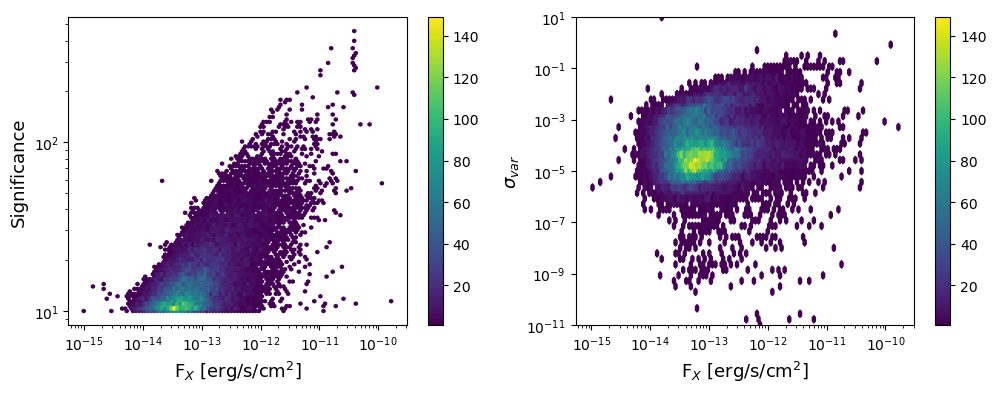

In [33]:
plt.subplots(figsize=(12, 4))
plt.subplot(1,2,1)
idx = (cat['flux_aper_b'] > 0) & (cat['flux_significance_b'] > 0)
plt.hexbin(cat['flux_aper_b'][idx], cat['flux_significance_b'][idx],
           xscale='log', yscale='log', mincnt=1)
plt.colorbar()
plt.xlabel('F$_X$ [erg/s/cm$^2$]',size=13)
plt.ylabel('Significance',size=13);
plt.subplot(1,2,2)
idx = (cat['flux_aper_b'] > 0) & (cat['var_sigma_b'] > 0)
plt.hexbin(cat['flux_aper_b'][idx], cat['var_sigma_b'][idx],
           xscale='log', yscale='log', mincnt=1)
plt.colorbar()
plt.xlabel('F$_X$ [erg/s/cm$^2$]',size=13)
plt.ylabel('$\sigma_{var}$',size=13);
plt.ylim(1e-11,1e1)

So we see that at the level of individual observation detections, sgnificance and flux are correlated. The dispersion in significance for a give flux has to do with the background level and the off-axis angle of the detection. We also see that at a given flux there is a range of variability sigmas. Those with larger values are those with larger variations in the light curve with respect to the mean flux.


### Retrieving and displaying data products (light curves and spectra)
Let's now select a variable detection and obtain its light curve from the catalog. We can use CIAO tools for this, in particular, [*search_csc*](https://cxc.cfa.harvard.edu/ciao/ahelp/search_csc.html). Please note that using *search_csc* for bulk downloads (for example, download all catalog light curves) can saturate the server. For bulk downloads, users should issue a ["Special Request"](https://cxc.cfa.harvard.edu/cgi-gen/cda/specreq) to the Chandra Data Archive.

First, let's print some detections (and the corresponding source name and coordinates) that have fluxes larger than 5E-13 erg/s/cm2 and var_sigma_b larger than 1E-3. Additionally, let's select detections that are close to on-axis, using the off-axis angle *theta*, which is given in arcmin:

In [34]:
index = (cat['flux_aper_b']>5E-13) & (cat['flux_aper_b']<1E-12) & (cat['var_sigma_b']>1E-3) & (cat['theta'] < 3)
print('name,  obsid,  region_id, ra,  dec')
for i in range(20):
    print(cat['name'][index].data[i],
         cat['obsid'][index].data[i],
         cat['region_id'][index].data[i],
         cat['ra'][index].data[i],
         cat['dec'][index].data[i])

name,  obsid,  region_id, ra,  dec
2CXO J002403.5-720452 3384 143 6.014330003149098 -72.08116831118384
2CXO J002404.2-720457 78 72 6.017589465794288 -72.08283964330204
2CXO J002404.2-720457 15748 72 6.017589465794288 -72.08283964330204
2CXO J002404.2-720457 2735 129 6.017589465794288 -72.08283964330204
2CXO J002404.2-720457 3384 129 6.017589465794288 -72.08283964330204
2CXO J004732.9-251748 3931 431 11.887446788603597 -25.297027045405496
2CXO J004742.7-251502 3931 129 11.92825353176039 -25.250688082430138
2CXO J011448.6-002946 18161 4 18.70280813114033 -0.49616083820505225
2CXO J013334.1+303211 6384 49 23.3922218123177 30.536418751153672
2CXO J013334.1+303211 7171 49 23.3922218123177 30.536418751153672
2CXO J013418.2-292506 16351 146 23.5758848194572 -29.41854343386345
2CXO J020029.6-023959 26150 6 30.123452044930445 -2.666559065292448
2CXO J020924.5-100809 15666 221 32.35251454935246 -10.135869300307114
2CXO J020924.5-100809 15667 221 32.35251454935246 -10.135869300307114
2CXO J023546

*search_csc* can only perform a coordinate based search (or the name of a SIMBAD-recognized object). So, let's pick the first source, and do a search around its location with a search radius of 1 arcsec. We will request the light curve ('lc') for the broad band, as well as the spectral files (pha, arf, rmf). The command will also provide a table (source_search.tsv) with a summary of catalog properties for the retrieved sources (in this case, a single source).

In [26]:
search_csc('38.94521969459174, 34.68734478897538','1.0','test1.tsv','arcsec','', 'no', 'all', 
           PATH, 'broad', 'lc,pha,rmf,arf', 'cur','1','1')

search_csc
             pos = 38.94521969459174, 34.68734478897538
          radius = 1
         outfile = test1.tsv
         radunit = arcsec
         columns = 
     sensitivity = no
        download = all
            root = /Users/juan/L3/tutorial
           bands = broad
       filetypes = lc,pha,rmf,arf
         catalog = current
         verbose = 1
         clobber = yes
            mode = hl


2 rows returned by query
1 Different Master Source(s).
2 Different Observation(s).

name                	ra          	dec         	sepn	obsid	
 2CXO J023546.8+344115	3.894522e+01	3.468734e+01	0"	26201	
 2CXO J023546.8+344115	3.894522e+01	3.468734e+01	0"	 1870	
Retrieving files for obsid_obi 26201_000
Retrieved file /Users/juan/L3/tutorial/2CXOJ023546.8+344115/26201_000/acisf26201_000N030_r0004_pha3.fits
Retrieved file /Users/juan/L3/tutorial/2CXOJ023546.8+344115/26201_000/acisf26201_000N030_r0004_arf3.fits
Retrieved file /Users/juan/L3/tutorial/2CXOJ023546.8+344115/26201_000/acisf26201_00

We have retrieved all the observations of the source. For now we are interested only in the detection of this source that we had identified as being variable a couple of cells above, which is the detection of this soruce in obsid 78. We will use astropy to load the fits file we have just downloaded. Note that the light curve file has both a source, and a background light curve.

In [35]:
hdul = fits.open(PATH+'2CXOJ032912.9+311814/00642_000/acisf00642_000N026_r0024b_lc3.fits.gz')

In [36]:
hdul.info()

Filename: /Users/juan/L3/tutorial/2CXOJ032912.9+311814/00642_000/acisf00642_000N026_r0024b_lc3.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  LIGHTCURVE    1 BinTableHDU    186   42R x 5C   [1D, 1D, 1D, 1D, 1D]   
  2  BKGLIGHTCURVE    1 BinTableHDU    168   42R x 5C   [1D, 1D, 1D, 1D, 1D]   


Let's now plot the light curve, with its error bars. 

Text(0.5, 1.0, '2CXO J032912.9+311814, obsid 642')

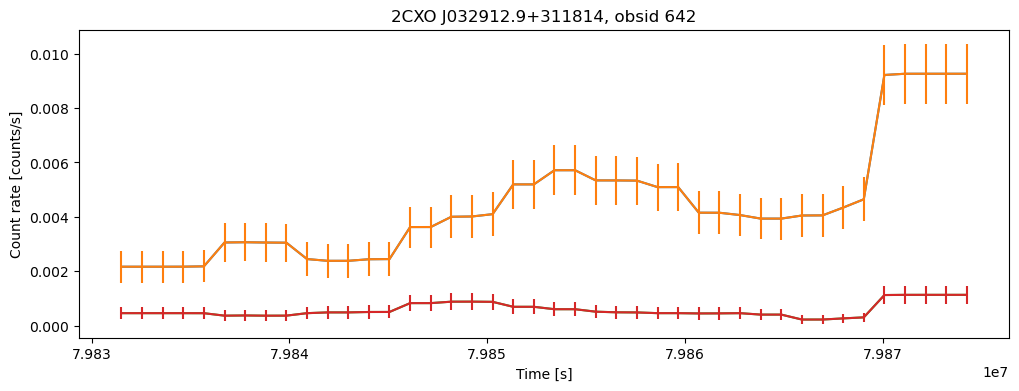

In [37]:
lc3 = hdul[1].data
bg3 = hdul[2].data

plt.subplots(figsize=(12, 4))
plt.plot(lc3['Time'],lc3['COUNT_RATE'])
plt.errorbar(lc3['Time'],lc3['COUNT_RATE'],lc3['COUNT_RATE_ERR'])

#plt.subplots(figsize=(12, 4))
plt.plot(bg3['Time'],bg3['COUNT_RATE'])
plt.errorbar(bg3['Time'],bg3['COUNT_RATE'],bg3['COUNT_RATE_ERR'])

plt.xlabel('Time [s]')
plt.ylabel('Count rate [counts/s]')
plt.title('2CXO J032912.9+311814, obsid 642')

This variable source has an interesting light curve (as determined using the [Gregory-Loredo algorithm](https://cxc.cfa.harvard.edu/csc/why/gregory_loredo.html)). The light curve shows clear flickering/flaring behavior. In fact, if we investigate, further, we realize that this source correspond to [a magnetic cataclysmic variable](https://ui.adsabs.harvard.edu/abs/2001Sci...292.2290G/abstract) in the globular cluster 47 Tuc.

We can also visualize the catalog spectra we downloaded for this source using Sherpa (and then do with it all the cool spectral fitting that you have seen in the BXA tutorials, and that you will see in the Sherpa tutorials):

In [38]:
hdu = fits.open(PATH+'acisf06436_000N026_r0118_pha3.fits.gz')

In [39]:
hdu.info()

Filename: /Users/juan/L3/tutorial/acisf06436_000N026_r0118_pha3.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  SPECTRUM      1 BinTableHDU    378   1024R x 4C   [1J, 1D, 1J, 1D]   
  2  GTI           3 BinTableHDU     33   1R x 2C   [1D, 1D]   
  3  GTI           6 BinTableHDU     33   1R x 2C   [1D, 1D]   
  4  GTI           7 BinTableHDU     33   1R x 2C   [1D, 1D]   
  5  GTI           2 BinTableHDU     33   1R x 2C   [1D, 1D]   
  6  GTI           1 BinTableHDU     33   1R x 2C   [1D, 1D]   
  7  GTI           0 BinTableHDU     33   3R x 2C   [1D, 1D]   
  8  MASK          1 ImageHDU        55   (69, 69)   uint8   
  9  SPECTRUM      2 BinTableHDU    301   1024R x 4C   [1J, 1D, 1J, 1D]   
 10  MASK          2 ImageHDU        56   (69, 69)   uint8   


In [40]:
ui.load_pha(PATH+'2CXOJ023546.8+344115/26201_000/acisf26201_000N030_r0004_pha3.fits.gz')

read ARF file /Users/juan/L3/tutorial/2CXOJ023546.8+344115/26201_000/acisf26201_000N030_r0004_arf3.fits
read RMF file /Users/juan/L3/tutorial/2CXOJ023546.8+344115/26201_000/acisf26201_000N030_r0004_rmf3.fits
read background file /Users/juan/L3/tutorial/2CXOJ023546.8+344115/26201_000/acisf26201_000N030_r0004_pha3.fits


Let's restrict the energy range, and also bin the counts in constructing the spectrum.

In [41]:
ui.ignore('0.:0.5,8.0:')
ui.subtract()
#ui.notice_id(1,0.3,7.)
ui.group_counts(10)

dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)


(0.4, 10)

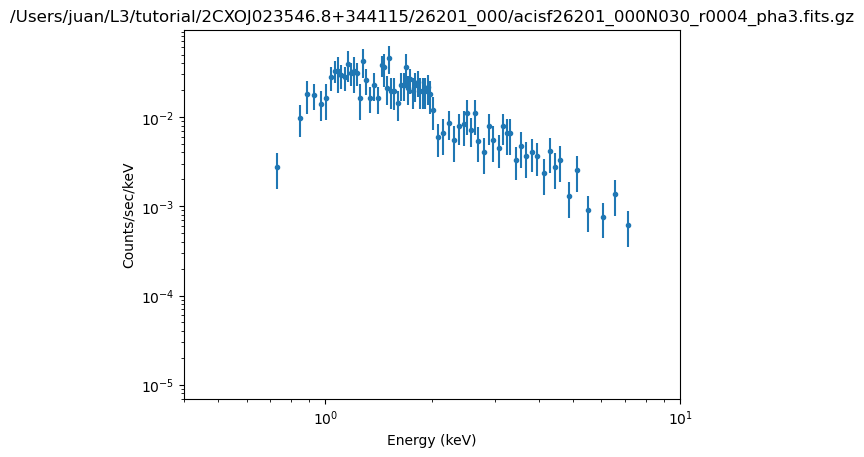

In [42]:
ui.set_ylog()
ui.set_xlog()
ui.plot_data()
plt.xlim(4E-1,10)

### Fitting spectra with Sherpa and BXA
Now that we have downloaded and visualized the spectral files, we can now fit some spectral models to the observed spectrum using [BXA](https://johannesbuchner.github.io/BXA/index.html) working under Sherpa. BXA works as a plug-in to Sherpa that allows for a Bayesian approach to spectral fitting using [nested sampling](https://arxiv.org/pdf/2101.09675.pdf), which is an efficient way to sample complex posterior probability distributions. Nested sampling also allows for the computation of the Bayesian evidence, which can be thought of as the normalization factor in Bayes' rule, and that allows to easily compare models. For demonstrations pruposes, we will only use here a simple absorbed model with a power-law component and a blackbody disk component model, but we encourage the users to explore the capabilities of BXA, and to use the CSC provided spectra for their sience projects. We start by setting a statistic to minimize, and set the units to energy units, and we define a simple absorbed power law as our model:

In [43]:
ui.set_stat('chi2gehrels')
ui.set_analysis('ener')

We fix the $n_H$ value to the value expected towards the line of sight of our source using the HEASARC's [$n_H$ calculator](https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3nh/w3nh.pl?Entry=6.01784+-72.08276&NR=GRB%2FSIMBAD%2BSesame%2FNED&CoordSys=Equatorial&equinox=2000&radius=0.1&usemap=0).

In [44]:
ui.set_source('xsphabs.abs1 * (powlaw1d.p1 + xsdiskbb.p2)')
p1.ampl.min = 1E-5
p2.norm.min = 1E-5
abs1.nH = 0.053
ui.freeze(abs1.nH)

In [45]:
ui.show_model()

Model: 1
apply_rmf(apply_arf((20805.207294716 * (xsphabs.abs1 * (powlaw1d.p1 + xsdiskbb.p2)))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   abs1.nH      frozen        0.053            0        1e+06 10^22 atoms / cm^2
   p1.gamma     thawed            1          -10           10           
   p1.ref       frozen            1 -3.40282e+38  3.40282e+38           
   p1.ampl      thawed            1        1e-05  3.40282e+38           
   p2.Tin       thawed            1            0         1000        keV
   p2.norm      thawed            1        1e-05        1e+24           



In [46]:
# Make an initial guess of the model parameters
ui.guess(p1)

In [47]:
ui.show_model()

Model: 1
apply_rmf(apply_arf((20805.207294716 * (xsphabs.abs1 * (powlaw1d.p1 + xsdiskbb.p2)))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   abs1.nH      frozen        0.053            0        1e+06 10^22 atoms / cm^2
   p1.gamma     thawed            1          -10           10           
   p1.ref       frozen            1 -3.40282e+38  3.40282e+38           
   p1.ampl      thawed  0.000164077  1.64077e-07     0.164077           
   p2.Tin       thawed            1            0         1000        keV
   p2.norm      thawed            1        1e-05        1e+24           



We now set the probabilistic model by setting the priors and starting a solver. Note that we do not need to define a likelihood, as we have already stated early on that we will use a particular statistic (chi2reghels) that directly links to the likelihood.

In [48]:
# parameters we want to vary
param1 = p1.gamma
param2 = p1.ampl
param3 = p2.Tin
param4 = p2.norm

# list of parameters
parameters = [param1, param2, param3, param4]
# list of prior transforms
priors = [
   bxa.create_uniform_prior_for(param1),
   bxa.create_loguniform_prior_for(param2), 
   bxa.create_uniform_prior_for(param3),
   bxa.create_loguniform_prior_for(param4),     
]

# make a single function:
priorfunction = bxa.create_prior_function(priors)

Note that the solver will also provide the final value of the Bayesian evidence Z. We can use this number to compare between models. This is where the power of statistics helps us compare models and decide which model is better at describing the data.

In [47]:
# see the pymultinest documentation for all options
solver = bxa.BXASolver(prior=priorfunction, parameters=parameters,
             outputfiles_basename = "myoutputs_test_head20/")
results = solver.run(resume=True)

[ultranest] Resuming from 400 stored points


/Users/juan/opt/anaconda3/envs/ciao-4.15/lib/python3.8/site-packages/ultranest/integrator.py:1756: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points (stored for you in myoutputs_test_head20/extra/sampling-stuck-it%d.csv) are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-24.9786..-24.9784]*| it/evals=8912/671093 eff=1.3280% N=400 
[ultranest] Likelihood function evaluations: 671156
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -42.49 +- 0.1443
[ultranest] Effective samples strategy satisfied (ESS = 1795.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -42.499 +- 0.314
  single instance: logZ = -42.499 +- 0.200
  bootstrapped   : logZ = -42.486 +- 0.313
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    p1.gamma            : 0.14  │ ▁▁▁▁   ▁   ▁▁▁▁▁▁▁▃▅▇▆▄▄▄▃▂▂▁▁▁▁▁▁ ▁▁ │3.76      2.29 +- 0.28
    p1.ampl             : 

(0.1, 10)

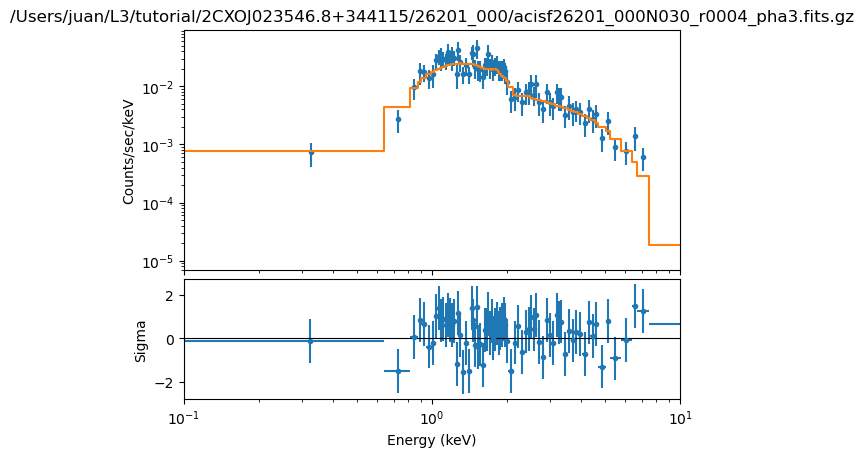

In [48]:
ui.set_ylinear()
ui.set_xlinear()
ui.plot_fit_delchi(xlog=True, ylog=True)
plt.xlim(1E-1,10)

## Cross-matching the CSC2 with other catalogs

Now we will explore how to cross-match the catalog with other catalogs for multi-wavelenght analysis. Here we will use both Gaia and the 2MASS catalog to explore the optical, infrared and X-ray properties of sources in the Westerhout 40 (W40) star forming region. In the case of Gaia, we will also demonstrate the improvements in astrometry in CSCS 2.1 with respect to CSC 2.0. Let's start by doing a cone search to select CSC2 sources in the W40 field, just as we have done before with M50, bit with a different search radius.:

In [43]:
cone2 = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch') #CSC2
cone21 = vo.dal.SCSService('https://cda.cfa.harvard.edu/csc21_snapshot_scs/coneSearch') #CSC21

W40 = SkyCoord.from_name('W40')

maxrad = 40.0 * u.arcmin
results2 = cone2.search(pos=W40, radius=maxrad)
results21 = cone21.search(pos=W40, radius=maxrad)

print('Your query resulted in ',len(results2),'CSC 2.0 sources')
print('Your query resulted in ',len(results21),'CSC 2.1 sources')

Your query resulted in  319 CSC 2.0 sources
Your query resulted in  407 CSC 2.1 sources


It looks like we have gained sources in the new version of the catalog. That is good, and the result of additional observations being added in this area of the sky. Let's now get the coordinates of the CSC sources both in the CSC 2.0 and CSC 2.1 versions. Let's get the coordinates for each set:

In [44]:
results21.fieldnames

('name',
 'ra',
 'dec',
 'err_ellipse_r0',
 'conf_flag',
 'extent_flag',
 'sat_src_flag',
 'flux_aper_b',
 'flux_aper_lolim_b',
 'flux_aper_hilim_b',
 'flux_aper_w',
 'flux_aper_lolim_w',
 'flux_aper_hilim_w',
 'significance',
 'hard_hm',
 'hard_hm_lolim',
 'hard_hm_hilim',
 'hard_ms',
 'hard_ms_lolim',
 'hard_ms_hilim',
 'var_intra_index_b',
 'var_intra_index_w',
 'var_inter_index_b',
 'var_inter_index_w')

In [45]:
csc2_coords = SkyCoord(
    ra=results2['ra']*u.deg,
    dec=results2['dec']*u.deg)

In [46]:
csc21_coords = SkyCoord(
    ra=results21['ra']*u.deg,
    dec=results21['dec']*u.deg)

In [47]:
Gaia.ROW_LIMIT = 600000  # Ensure the default row limit.

In [48]:
coord = SkyCoord(ra=W40.ra.deg, dec=W40.dec.deg, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(80.0, u.arcmin)
height = u.Quantity(40.0, u.arcmin)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

r.pprint(max_lines=12, max_width=130)

INFO: Query finished. [astroquery.utils.tap.core]
         dist             solution_id     ...                                     datalink_url                                   
                                          ...                                                                                    
--------------------- ------------------- ... -----------------------------------------------------------------------------------
 0.003032017223787457 1635721458409799680 ... https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+4270235912243818624
 0.005673758685837328 1635721458409799680 ... https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+4270235912237498880
0.0073267932182245225 1635721458409799680 ... https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+4270235912237498752
                  ...                 ... ...                                                                                 ...
   0.7402807997774589 163572145840979968

Let's plot a few of the source matches in the central region of W43. We attempt to highlight the improvement is astrometry by showing a better agreement in CSC 2.1 with the Gaia positions. A systematic shift in the coordinates is evident in the plot.

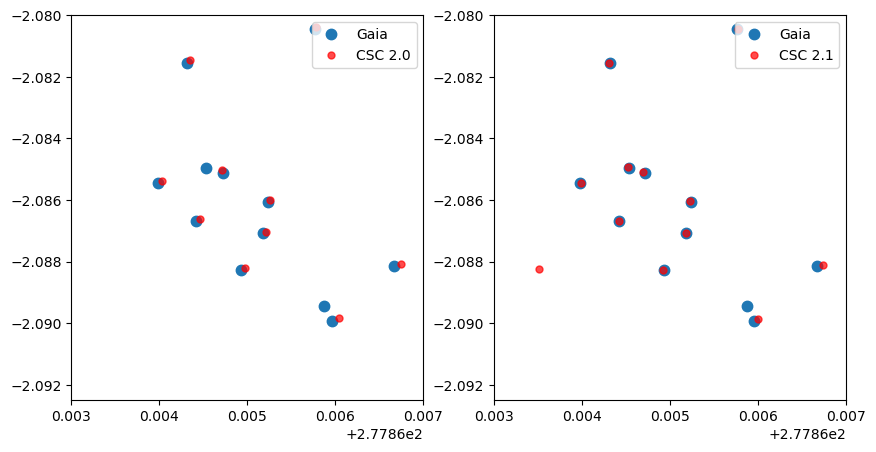

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fact = 1.0

ax = axes[0]
ax.plot(r['ra'],r['dec'],'.',ms=15,label='Gaia')
ax.plot(fact*csc2_coords.ra.deg,fact*csc2_coords.dec.deg,'.',ms=10,color='red',alpha=0.7,label='CSC 2.0')
ax.set_xlim(277.863,277.867)
ax.set_ylim(-2.0925,-2.08)
ax.legend(loc=1)

ax = axes[1]
ax.plot(r['ra'],r['dec'],'.',ms=15,label='Gaia')
ax.plot(fact*csc21_coords.ra.deg,fact*csc21_coords.dec.deg,'.',ms=10,color='red',alpha=0.7,label='CSC 2.1')
ax.set_xlim(277.863,277.867)
ax.set_ylim(-2.0925,-2.08)
ax.legend(loc=1)

By how much has the systematic component of the position error improved in CSC 2.1 for this particular field? in order to figure it out, let's plot the histogram of the separations between matches that are less than 1 arcsecond, for both the CSC 2.0 matches and the CSC 2.1 matches with Gaia.

In [50]:
gaia_coords = SkyCoord(r['ra'],
                        r['dec'])

In [51]:
max_sep = 1.0 * u.arcsec
idx_, sep2d_, _ = csc2_coords.match_to_catalog_sky(
    gaia_coords)

In [52]:
max_sep = 1.0 * u.arcsec
idx1_, sep2d1_, _ = csc21_coords.match_to_catalog_sky(
    gaia_coords)

In [53]:
max_sep = 1.0 * u.arcsec
idxg_, sep2dg_, _ = gaia_coords.match_to_catalog_sky(
    csc2_coords)

In [54]:
max_sep = 1.0 * u.arcsec
idx1g_, sep2d1g_, _ = gaia_coords.match_to_catalog_sky(
    csc21_coords)

In [55]:
len(idx_[np.where(sep2d_.arcsec<1.0)])

110

(0.009, 2)

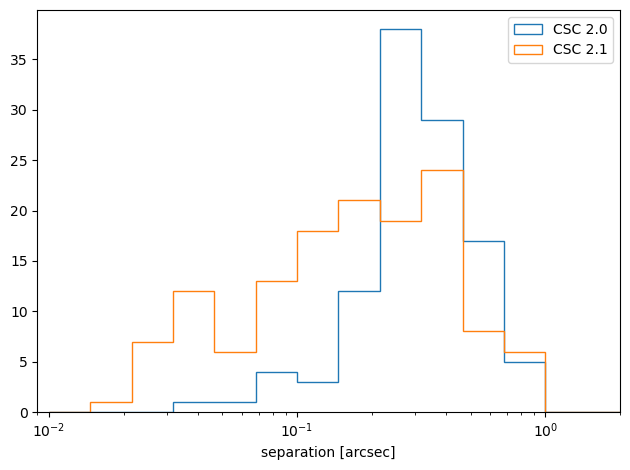

In [56]:
plt.hist(sep2d_.arcsec[np.where(sep2d_.arcsec<1.0)], histtype='step',
         bins=np.logspace(-2, 2., 25),label='CSC 2.0',density=False)
plt.hist(sep2d1_.arcsec[np.where(sep2d1_.arcsec<1.0)], histtype='step',
         bins=np.logspace(-2, 2., 25),label='CSC 2.1',density=False)
plt.xlabel('separation [arcsec]')
plt.xscale('log')
#plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.xlim(9E-3,2)

And now the cumulative version

(0.01, 1)

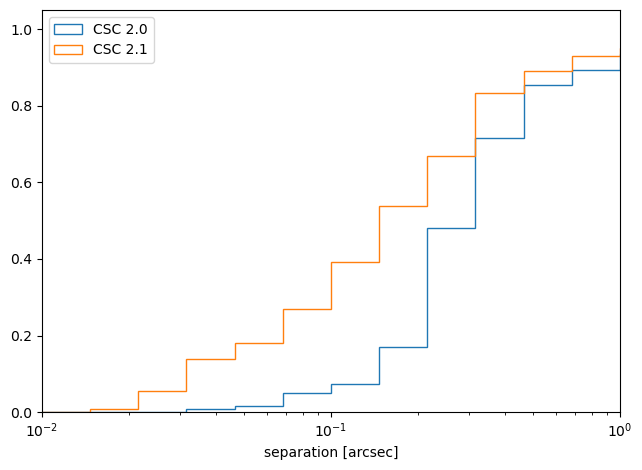

In [57]:
plt.hist(sep2d_.arcsec[np.where(sep2d_.arcsec<3.0)], histtype='step',
         bins=np.logspace(-2, 2., 25),density=True,cumulative=True,label='CSC 2.0')
plt.hist(sep2d1_.arcsec[np.where(sep2d1_.arcsec<3.0)], histtype='step',
         bins=np.logspace(-2, 2., 25),density=True,cumulative=True,label='CSC 2.1')
plt.xlabel('separation [arcsec]')
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc=2)
plt.tight_layout()
plt.xlim(1E-2,1)

We note a significant improvement in the systematic component of the position uncertainty in CSC 2.1 versus CSC 2.0. For example, in CSC2.0 only about 20% of the W40 CSC sources had a separation of 0.2 arcsec of less with a Gaia counterpart. In contrast, in CSC 2.1, that percentage is about 55%. 

### The Hertzprung-Russell Diagram and X-ray emission for Westerhout 40
We will now use the cross matching we have produced in order to porduce a HR diagram for the young stars in the W40 star-forming region. We will also see if there is a correlation between their evolutionary stage and their X-ray properties. Using the Gaia absolute G magnitude as a measure of luminosity and the Gaia $BP-RP$ color as a measure of temperature, we will produce HR diagrams and color code them according to the X-ray hardness and the X-ray luminosity of the sources

Text(0, 0.5, 'log(flux_aper_b)')

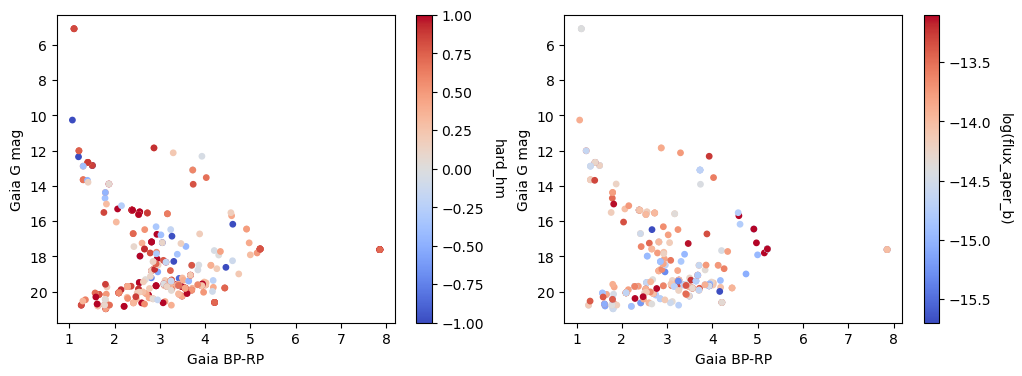

In [58]:
plt.subplots(figsize=(12, 4))
cmap = cm.coolwarm
normalize = matplotlib.colors.Normalize(vmin=-1, vmax=1)
plt.subplot(1,2,1)
plt.scatter(r['bp_rp'][idx1_],r['phot_g_mean_mag'][idx1_],cmap=cmap,norm=normalize,c=results21['hard_hm'].data,s=15)
plt.gca().invert_yaxis()
plt.xlabel('Gaia BP-RP')
plt.ylabel('Gaia G mag')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('hard_hm', rotation=270)
normalize = matplotlib.colors.Normalize(vmin=-15.7, vmax=-13.1)
plt.subplot(1,2,2)
plt.scatter(r['bp_rp'][idx1_],r['phot_g_mean_mag'][idx1_],cmap=cmap,norm=normalize,c=np.log10(results21['flux_aper_b'].data),s=15)
plt.gca().invert_yaxis()
plt.xlabel('Gaia BP-RP')
plt.ylabel('Gaia G mag')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(flux_aper_b)', rotation=270)

Low luminosity young stars appear to be harder in X-ray emission, whereas the most X-ray luminous sources appear to be the colder young stars.

### Cross-matching with the 2MASS catalog
We will now perform the cross-match of CSC 2.1 sources with the 2MASS catalog.

In [59]:
W40 = SkyCoord.from_name('W40')
maxrad = 40.0 * u.arcmin
results = cone21.search(pos=W40, radius=maxrad)
print('Your query resulted in ',len(results),'CSC21 sources')

Your query resulted in  407 CSC21 sources


Now let's use the astroquery to search Vizier for 2MASS sources:

In [60]:
# II/246 is the catalog name for the main 2MASS photometric catalog
v = Vizier(catalog="II/246", columns=['*', 'Date'])
v.ROW_LIMIT = -1

result = v.query_region(W40, radius=maxrad)
tmass_table = result[0]
print('Your query resulted in ',len(result[0]),'2MASS sources')

Your query resulted in  57325 2MASS sources


In [61]:
# The first 10 objects in the 2MASS query
tmass_table[0:10]

RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg,Date
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,,
float64,float64,str17,float32,float32,float32,float32,float32,float32,str3,str3,str3,str3,uint8,uint8,str10
277.614668,-2.689856,18302752-0241234,16.513,--,15.536,0.129,15.104,0.169,UBC,022,011,0cc,0,0,1999-04-05
277.615135,-2.687855,18302763-0241162,16.850,0.215,15.561,0.133,14.667,0.115,DBB,222,111,ccc,0,0,1999-04-05
277.619949,-2.689316,18302878-0241215,14.298,--,14.557,0.061,14.014,0.058,UAA,022,012,0cc,0,0,1999-04-05
277.618887,-2.689058,18302853-0241206,13.722,--,12.817,0.034,12.439,0.035,UAA,622,012,00c,0,0,1999-04-05
277.666947,-2.699953,18304006-0241598,15.561,0.064,13.844,0.033,13.133,0.047,AAA,222,111,ccc,0,0,1999-04-05
277.669612,-2.709261,18304070-0242333,16.848,0.238,14.727,--,14.632,0.206,DUC,202,101,c0c,0,0,1999-04-05
277.658275,-2.693687,18303798-0241372,10.229,0.025,8.170,0.033,7.191,0.023,AAA,211,111,000,0,0,1999-04-05
277.676010,-2.702157,18304224-0242077,17.213,--,15.409,0.099,14.489,0.108,UBA,022,012,00c,0,0,1999-04-05


Let's get the coordinates from the 2MASS catalog

In [62]:
tmass_coords = SkyCoord(tmass_table['RAJ2000'],
                        tmass_table['DEJ2000'])

And the coordinates from the table of CSC2 sources:

In [63]:
W40_coords_csc21 = SkyCoord(
    ra=results21['ra']*u.deg,
    dec=results21['dec']*u.deg)

Now let's perform the cross match using astropy's [*match_to_catalog_sky*](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.match_to_catalog_sky) tool, which is based on a nearest neighbors search:

In [64]:
idx_, sep2d_, _ = W40_coords_csc21.match_to_catalog_sky(
    tmass_coords)

Let's visualize the separations between matched sources. Note that this is a crowded field, with many nearest neighbors being incorrect matches. To mitigate this, let's choose only matches that belong to the small separation peak (i.e., those at less than 1 arcsec in separation) in the following two-peaked distribution:

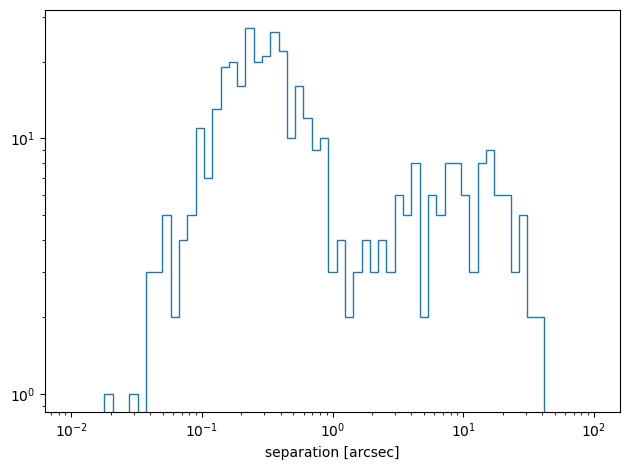

In [65]:
plt.hist(sep2d_.arcsec, histtype='step',
         bins=np.logspace(-2, 2., 64))
plt.xlabel('separation [arcsec]')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

We will create a color-hardness diagram, and an X-ray flux-IR magnitude diagram. Select the relevant properties from each table for only those matches with separations less than 1 arcsec:

In [66]:
Jmag1 = tmass_table['Jmag'][idx_][sep2d_.arcsec < 1.0]
Kmag1 = tmass_table['Kmag'][idx_][sep2d_.arcsec < 1.0]
flux_b1 = results21['flux_aper_b'][sep2d_.arcsec < 1.0]
hard_hm1 = results21['hard_hm'][sep2d_.arcsec < 1.0]

Let's only select objects where the X-ray flux is larger than 0.

In [67]:
Jmag = Jmag1[flux_b1>0]
Kmag = Kmag1[flux_b1>0]
flux_b = flux_b1[flux_b1>0]
hard_hm = hard_hm1[flux_b1>0]

Finally, let's visualize our diagrams:

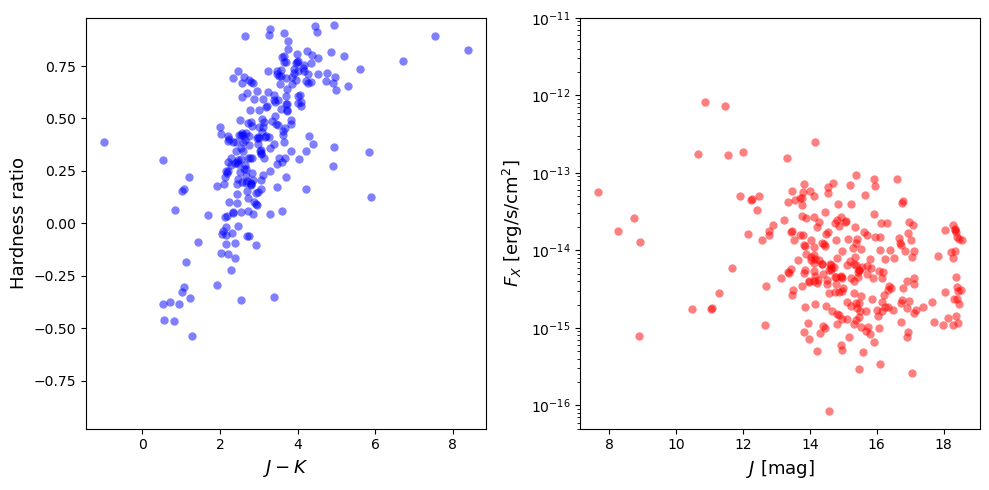

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(Jmag - Kmag, hard_hm,
           marker='o', color='b',
           linewidth=0, alpha=0.5)
ax.set_xlabel('$J - K$',size=13)
ax.set_ylabel('Hardness ratio',size=13)
#ax.set_xlim(-1, 6)
ax.set_ylim(-0.98,0.98) # backwards because magnitudes!

ax = axes[1]
ax.scatter(Jmag, flux_b,
           marker='o', color='r',
           linewidth=0, alpha=0.5)
ax.set_xlabel('$J$ [mag]',size=13)
ax.set_ylabel('$F_X$ [erg/s/cm$^2$]',size=13)
ax.set_yscale('log')
#ax.set_xlim(0.2, 1)
ax.set_ylim(5E-17, 1E-11) # backwards because magnitudes!

fig.tight_layout()

Looks like for young stellar objects, redder objects are also harder in X-rays. Perhaps hard X-ray flares resulting from magnetic reconnection in the surface of these stars are more common on YSO's where some of the redenning accretion disk is still detectable at near-IR wavelengths. Stars are also populating the expected locus of $F_x$ vs. $F_{NIR}$.

## Using your CSC2 data as input for a machine learning algorithm

Finally, let's see if we can input our cross-matched data to an algorithm for clustering using Scikit-learn. We are interested in knowing if we can group sources in W40 based on their combined X-rays and optical properties. We will use their Gaia luminosities and temperatures, as well as the X-ray flux and hardness ratios to perform K-means clustering using scikit-learn. K-means is an unsupervised machine learning method that will try to separate the sources in this multi-dimensional space of features.

We need to get an array 'X' that will be the input to the clustering algorithm. This array is a list of 5 features: the stellar temperature as traced by BP-RP, the stellar optical luminosity as traced by G mag, the two X-ray hardness rations, and the log of the X-ray flux:

In [69]:
BP_RP = r['bp_rp'][idx1_]
G = r['phot_g_mean_mag'][idx1_]
hard_hm = results21['hard_hm'].data
hard_ms = results21['hard_ms'].data
f_x = np.log10(results21['flux_aper_b'].data)

# Get rid of undefined hardness ratios
indices = (np.absolute(hard_hm)<0.98) & (np.absolute(hard_ms)<0.98)

BP_RP = BP_RP[indices]
G = G[indices]
hard_hm = hard_hm[indices]
hard_ms = hard_ms[indices]
f_x = f_x[indices]

# Construct the input array
X = []
for i in range(len(BP_RP)):
    X.append([BP_RP[i],G[i],hard_hm[i],hard_ms[i],f_x[i]])
    
print(len(X))

245


Note that this dataset contains only 245 objects, and we are also going to arbitrarily select n=8 as the number of clusters into which we will separate those objects. So, please do not over-interpret the results, as they are just marginally indicative when ot comes to source classification. But you can refine this by including more objects, more features, and also by carefully selecting the number of clusters.

Because some of the fluxes and magnitudes can be not defined, this means that our dataset has missing data, which usually does not go well with standard machine learning algorihtms. We could have imputed, by reemplazing the missing data with some reasonable guess (for example, the mean of the distribution for all the other objects that do have that feature defined). But that can introduce some bias. Instead, we are going to remove all objects that have mising data.

In [71]:
# Get rid of rows with missing data
X = np.array(X)
X_imputed = X[~np.ma.fix_invalid(X).mask.any(axis=1)]

Now we can run the K-means model, using 8 clusters, to fit our data:

In [72]:
y_pred = KMeans(n_clusters=8, random_state=None).fit_predict(X_imputed)

In [73]:
np.shape(X_imputed)

(176, 5)

Finally, let's plot the result:

Text(0, 0.5, 'log X-ray flux')

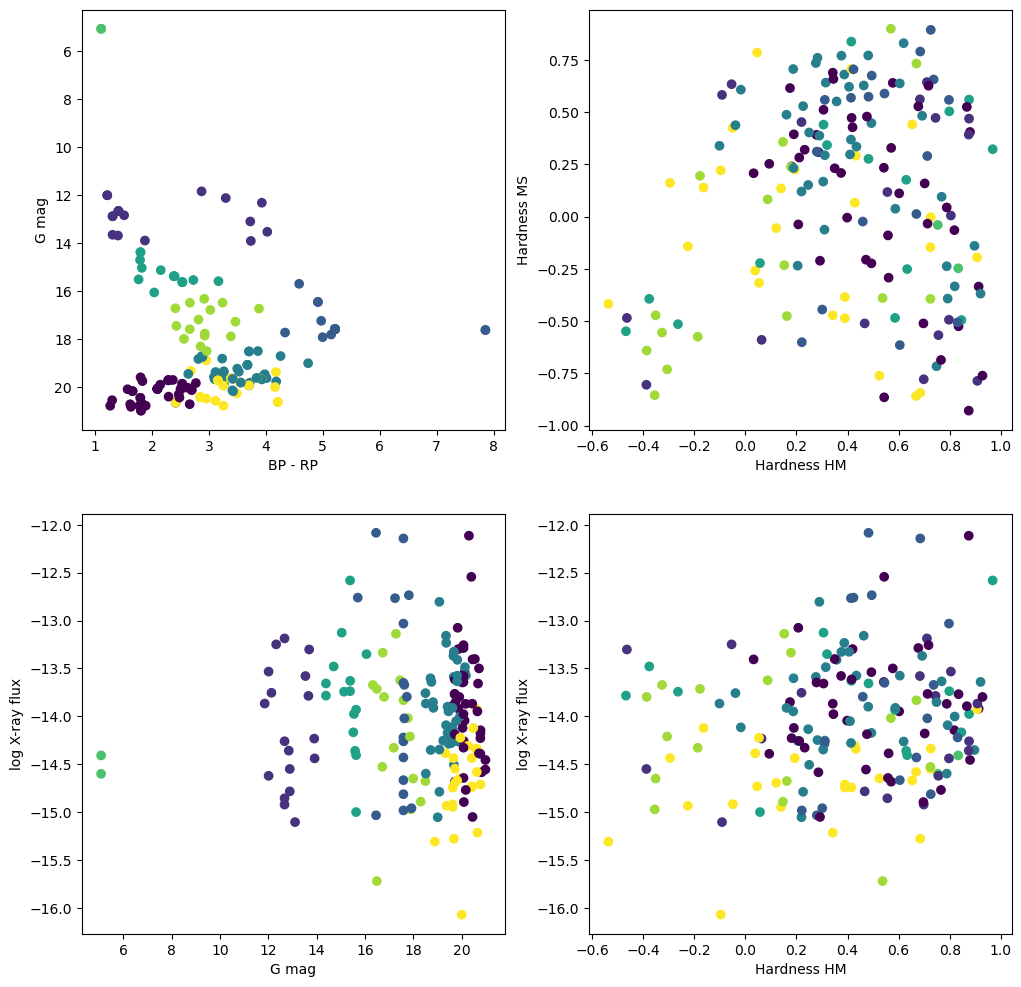

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_imputed[:, 0], X_imputed[:, 1], c=y_pred)
plt.xlabel('BP - RP')
plt.ylabel('G mag')
plt.gca().invert_yaxis()
plt.subplot(222)
plt.scatter(X_imputed[:, 2], X_imputed[:, 3], c=y_pred)
plt.xlabel('Hardness HM')
plt.ylabel('Hardness MS')
plt.subplot(223)
plt.scatter(X_imputed[:, 1], X_imputed[:, 4], c=y_pred)
plt.xlabel('G mag')
plt.ylabel('log X-ray flux')
plt.subplot(224)
plt.scatter(X_imputed[:, 2], X_imputed[:, 4], c=y_pred)
plt.xlabel('Hardness HM')
plt.ylabel('log X-ray flux')

Text(0, 0.5, 'G mag')

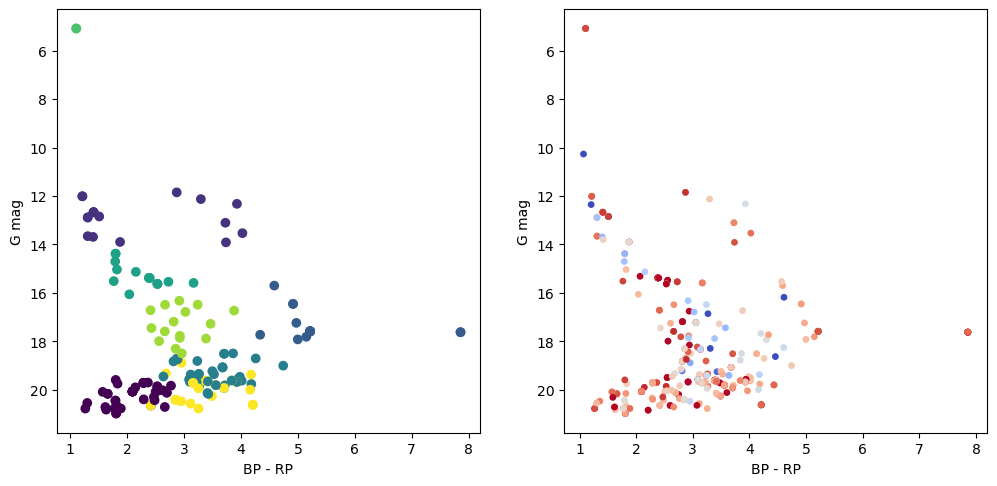

In [75]:
ig, axes = plt.subplots(1, 2, figsize=(12, 5.5))
plt.subplot(121)
normalize = matplotlib.colors.Normalize(vmin=-1, vmax=1)
plt.scatter(X_imputed[:, 0], X_imputed[:, 1], c=y_pred)
plt.xlabel('BP - RP')
plt.ylabel('G mag')
plt.gca().invert_yaxis()
plt.subplot(122)
plt.scatter(r['bp_rp'][idx1_],r['phot_g_mean_mag'][idx1_],cmap=cmap,norm=normalize,c=results21['hard_hm'].data,s=15)
plt.gca().invert_yaxis()
plt.xlabel('BP - RP')
plt.ylabel('G mag')

It appears that the stellar parameters from the optical data (Luminosity, temperature) dominate the clustering, but there is a small contribution from the X-ray properties, with soft sources more likely to be in a different cluster than hard sources.